# Iguazio Quick Start 

This notebook provides a quick overview of building an end to end machine learning pipeline on iguazio. <br>
This tutorial covers:
- Part 1: Loading iris data into the platform
- Part 2: Training a simple classification model with experiments tracking
- Part 3: Deploy a serving function
- Part 4: Creating an automated pipeline

In this demo we'll use two key open source frameworks:
* MLrun - Iguazio's ML orchestration tool
* Nuclio - serverless function framework used for deploying an online serrving function


#### Install MLRun package
To install the MLRun package or upgrade the version of an installed package run the command below. <br>

In [6]:
# uncomment the command below
!/User/align_mlrun.sh

     |████████████████████████████████| 804 kB 5.3 MB/s eta 0:00:01
     |████████████████████████████████| 802 kB 87.8 MB/s eta 0:00:01
     |████████████████████████████████| 51 kB 25.4 MB/s eta 0:00:01
     |████████████████████████████████| 10.9 MB 111.9 MB/s eta 0:00:01     | 2.6 MB 111.9 MB/s eta 0:00:01▏    | 9.3 MB 111.9 MB/s eta 0:00:01
     |████████████████████████████████| 298 kB 124.8 MB/s eta 0:00:01��████████████████         | 215 kB 124.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 113.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.7 MB 93.7 MB/s eta 0:00:01
     |████████████████████████████████| 119 kB 122.1 MB/s eta 0:00:01
     |████████████████████████████████| 208 kB 124.6 MB/s eta 0:00:01███████████  | 194 kB 124.6 MB/s eta 0:00:01
     |████████████████████████████████| 49 kB 61.0 MB/s eta 0:00:01
     |████████████████████████████████| 11.3 MB 57.6 MB/s eta 0:00:01               | 4.4 MB 57.6 MB/s eta 0:00:01
     |████████████

#### Kernel Restart
After installing or updating the MLRun package, restart the notebook kernel in your environment!

 ## Step 1: Create a project

Project is a key entity in Iguazio's platform. Every object we create (e.g. runs, functions, workflows, features, artifacts, models, etc.) are associated with a `project` namespace.<br>
Run the following code to initialize your MLRun environment to use a "quick-start-tutorial-&lt;username&gt;"project <br>
For more information about MLRun projects, see the MLRun [projects documentation](https://docs.mlrun.org/en/latest/projects/project.html).

In [1]:
from os import path
import mlrun

In [2]:
project_name_base = 'quick-start-tutorial'
project = mlrun.get_or_create_project(project_name_base, context="./", user_project=True)

> 2022-03-08 08:11:35,662 [info] loaded project quick-start-tutorial from MLRun DB


## Step 2: Load data

In this step you'll learn how to write a simple funciton that loads data into Iguazio platform and then how to convert it to a function (i.e. MLrun function) that can run on Iguazio's kubernetes cluster

The MLRun function has the following parameters:

- `context` - This allows you to log and retrieve information related to the function's execution.
- `source_url` - uses to send a data item as input when the function is called (using the `inputs` parameter).

The function code works as follows:
- Obtain a pandas DataFrame from the `source_url` data item by calling the `as_df` method.
- Record the number of rows using the `log_result` method. 
    This method records (logs) the values of standard function variables (for example, int, float, string, and list).
- Log the data-set artifact using the `log_dataset` method.
    This method saves and logs function data items and related metadata (logs function artifacts).

In [3]:
# mlrun: start-code

In [4]:
import mlrun
def prep_data(context, source_url: mlrun.DataItem, label_column='label'):

    # Convert the DataItem to a pandas DataFrame
    df = source_url.as_df()
    df[label_column] = df[label_column].astype('category').cat.codes    
    
    # Log the DataFrame size after the run
    context.log_result('num_rows', df.shape[0])

    # Store the dataset in your artifacts database
    context.log_dataset('cleaned_data', df=df, index=False, format='csv')

In [5]:
# mlrun: end-code

#### Converting the Notebook Code to a Function

Now, we'll take the code above and convert it to a code (i.e. mlrun function) that can run on kubernetes cluster. we'll be using a command called code_to_function for running the conversion.  MLRun annotations are used to identify the code that needs to be converted into an MLRun function.
They provide non-intrusive hints that indicate which parts of your notebook are the code of the function.
For more information on how to use MLRun functions, see [creating and using functions](https://docs.mlrun.org/en/latest/runtimes/using-functions.html).


In [6]:
# Convert the local prep_data function to an MLRun project function
data_prep_func = mlrun.code_to_function(name='prep_data', kind='job', image='mlrun/mlrun')

source_url = mlrun.get_sample_path("data/iris/iris.data.raw.csv")

prep_data_run = data_prep_func.run(name='prep_data',
                                   handler='prep_data',
                                   inputs={'source_url': source_url},
                                   local=False)

> 2022-03-08 08:11:49,795 [info] starting run prep_data uid=1b68f4020d884bdd83510fa4ce12a486 DB=http://mlrun-api:8080
> 2022-03-08 08:11:49,917 [info] Job is running in the background, pod: prep-data-tckvl
> 2022-03-08 08:12:28,712 [info] run executed, status=completed
final state: completed


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
quick-start-tutorial-admin,...ce12a486,0,Mar 08 08:12:27,completed,prep_data,v3io_user=adminkind=jobowner=adminmlrun/client_version=0.10.0host=prep-data-tckvl,source_url,,num_rows=150,cleaned_data


> 2022-03-08 08:12:29,320 [info] run executed, status=completed


<a id="gs-tutorial-1-step-run-func-on-cluster"></a>

## Step 3 -  Train a classification model

Next, we'll train a classifier model on the iris dataset. we'll use a training function that generates a model and log various model statistics and metadata. <br>
This will be done automatically by using MLRun `auto logging`. 
MLRun can apply all the MLOps functionality by simply using the framework specific `apply_mlrun()` method which manages the training process and automatically logs all the framework specific model details, data, metadata and metrics. 

To log the training results and store a model named `my_model`, we simply need to add the following lines:

``` python
from mlrun.frameworks.sklearn import apply_mlrun
apply_mlrun(model, context, model_name='my_model', x_test=X_test, y_test=y_test)
```


In [7]:
# mlrun: start-code

In [8]:
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from mlrun.frameworks.sklearn import apply_mlrun
import mlrun

In [9]:
def train_iris(dataset: mlrun.DataItem, label_column: str):
    
    # Initialize our dataframes
    df = dataset.as_df()
    X = df.drop(label_column, axis=1)
    y = df[label_column]

    # Train/Test split Iris data-set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Pick an ideal ML model
    model = ensemble.RandomForestClassifier()
    
    # Wrap our model with Mlrun features, specify the test dataset for analysis and accuracy measurements
    apply_mlrun(model=model, model_name='my_model', x_test=X_test, y_test=y_test)
    
    # Train our model
    model.fit(X_train, y_train)

In [10]:
# mlrun: end-code

In [11]:
train_iris_func = mlrun.code_to_function(name='train_iris',
                                         handler='train_iris',
                                         kind='job',
                                         image='mlrun/mlrun')

In [12]:
# Our dataset location (uri)
dataset = project.get_artifact_uri('prep_data_cleaned_data')

In [13]:
# train the model
train_run = train_iris_func.run(inputs={'dataset': dataset},
                                params={'label_column': 'label'},local=True)

> 2022-03-08 08:13:15,507 [info] starting run train-iris-train_iris uid=af978d254dc1496b8c1e2d2b4b6113f0 DB=http://mlrun-api:8080


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
quick-start-tutorial-admin,...4b6113f0,0,Mar 08 08:13:15,completed,train-iris-train_iris,v3io_user=adminkind=owner=adminhost=jupyter-admin-5f8d9cd4d8-mz42n,dataset,label_column=label,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0,feature-importancetest_setconfusion-matrixroc-curvesmodel


> 2022-03-08 08:13:17,147 [info] run executed, status=completed


## Step 4 - Deploy the model with an endpoint

Next, we'll deploy the model as a serving function with a http endpoint. This enable users to send http requests and get the response back

The serving class is initialized automatically by the model server.
All you need is to implement two mandatory methods:

- `load` &mdash; downloads the model files and loads the model into memory.
    This can be done either synchronously or asynchronously.
- `predict` &mdash; accepts a request payload and returns prediction (inference) results.

For more detailed information on serving classes, see the [MLRun documentation](https://github.com/mlrun/mlrun/blob/release/v0.6.x-latest/mlrun/serving/README.md).

The following code demonstrates a minimal scikit-learn (a.k.a. sklearn) serving-class implementation:

In [14]:
# mlrun: start-code

In [15]:
from cloudpickle import load
import numpy as np
from typing import List
import mlrun

class ClassifierModel(mlrun.serving.V2ModelServer):
    def load(self):
        """load and initialize the model and/or other elements"""
        model_file, extra_data = self.get_model('.pkl')
        self.model = load(open(model_file, 'rb'))

    def predict(self, body: dict) -> List:
        """Generate model predictions from sample."""
        feats = np.asarray(body['inputs'])
        result: np.ndarray = self.model.predict(feats)
        return result.tolist()

In [16]:
# mlrun: end-code

To provision (deploy) a function for serving the model ("a serving function") you need to create an MLRun function of type `serving`.
You can do this by using the `code_to_function` MLRun method from a web notebook, or by importing an existing serving function or template from the MLRun functions marketplace.

The following code converts the `ClassifierModel` class that you defined in the previous step to a serving function.
The name of the class to be used by the serving function is set in `spec.default_class`.

In [17]:
serving_fn = mlrun.code_to_function('serving', kind='serving',image='mlrun/mlrun')
serving_fn.spec.default_class = 'ClassifierModel'

Add the model created in previous notebook by the training function  


In [18]:
model_file = project.get_artifact_uri('my_model') 
serving_fn.add_model('my_model',model_path=model_file)

<a id="gs-tutorial-3-test-func-locally"></a>

### Testing Your Function Locally

To test your function locally, create a test server (mock server) and test it with sample data.

In [19]:
my_data = '''{"inputs":[[5.1, 3.5, 1.4, 0.2],[7.7, 3.8, 6.7, 2.2]]}'''

In [20]:
server = serving_fn.to_mock_server()
server.test("/v2/models/my_model/infer", body=my_data)

> 2022-03-08 08:13:34,013 [info] model my_model was loaded
> 2022-03-08 08:13:34,014 [info] Loaded ['my_model']


{'id': 'ac38eedf717443ee8daa4f3afda30fb0',
 'model_name': 'my_model',
 'outputs': [0, 2]}

<a id="gs-tutorial-3-building-and-deploying-the-serving-function"></a>

### Building and Deploying the Serving Function

Use the `deploy` method of the MLRun serving function to build and deploy a Nuclio serving function from your serving-function code.

In [21]:
function_address = serving_fn.deploy()

> 2022-03-08 08:13:35,146 [info] Starting remote function deploy
2022-03-08 08:13:35  (info) Deploying function
2022-03-08 08:13:35  (info) Building
2022-03-08 08:13:35  (info) Staging files and preparing base images
2022-03-08 08:13:35  (info) Building processor image
2022-03-08 08:14:31  (info) Build complete
2022-03-08 08:14:36  (info) Function deploy complete
> 2022-03-08 08:14:36,606 [info] successfully deployed function: {'internal_invocation_urls': ['nuclio-quick-start-tutorial-admin-serving.default-tenant.svc.cluster.local:8080'], 'external_invocation_urls': ['quick-start-tutorial-admin-serving-quick-start-tutorial-admin.default-tenant.app.product-3-2-3-a.iguazio-cd0.com/']}


<a id="gs-tutorial-1-step-schedule-jobs"></a>

### Testing the Live Model-Serving Function

After the function is deployed successfully, the serving function has a new HTTP endpoint for handling serving requests.
The example tutorial serving function receives HTTP prediction (inference) requests on this endpoint;
calls the `infer` method to get the requested predictions; and returns the results on the same endpoint.

In [22]:
print (f'The address for the function is {function_address} \n')

!curl $function_address

The address for the function is http://quick-start-tutorial-admin-serving-quick-start-tutorial-admin.default-tenant.app.product-3-2-3-a.iguazio-cd0.com/ 

{"name": "ModelRouter", "version": "v2", "extensions": []}

### Testing the Model Server

Test your model server by sending data for inference.
The `invoke` serving-function method enables programmatic testing of the serving function.
For model inference (predictions), specify the model name followed by `infer`:
```
/v2/models/{model_name}/infer
```
For complete model-service API commands &mdash; such as for list models (`models`), get model health (`ready`), and model explanation (`explain`) &mdash; see the [MLRun documentation](https://github.com/mlrun/mlrun/blob/release/v0.6.x-latest/mlrun/serving/README.md#model-server-api).

In [23]:
serving_fn.invoke('/v2/models/my_model/infer', my_data)

> 2022-03-08 08:14:40,613 [info] invoking function: {'method': 'POST', 'path': 'http://nuclio-quick-start-tutorial-admin-serving.default-tenant.svc.cluster.local:8080/v2/models/my_model/infer'}


{'id': '1f0732d8-c668-4403-b9ef-e6b64d759092',
 'model_name': 'my_model',
 'outputs': [0, 2]}

<a id="gs-tutorial-3-step-view-serving-func-in-ui"></a>

### Viewing the Nuclio Serving Function on the Dashboard

On the **Projects** dashboard page, select the project and then select "Real-time functions (Nuclio)".

![Nuclio](../assets/images/nuclio-deploy.png)

<a id="gs-tutorial-4-step-run-pipeline"></a>

## Step 5: Running A Pipeline

Now, let's build an automated pipeline that comprises of all the steps above. <br> First run the following code to save your project:

In [24]:
project.set_function('quick-start.ipynb', 'prep-data', kind='job', image='mlrun/mlrun')
project.set_function('quick-start.ipynb', 'train', kind='job', image='mlrun/mlrun', handler='train_iris')

# set project level parameters and save
project.spec.params = {'label_column': 'label'}
project.save()

In [25]:
# Register the workflow file as "main"
project.set_workflow('main', 'workflow.py')

In [26]:
project.save()

Use the `run` MLRun project method to execute your workflow pipeline with Kubeflow Pipelines. <br>
The tutorial code sets the following method parameters; (for more information on running workflows, see the [Project workflow and automation](https://docs.mlrun.org/en/latest/projects/workflows.html)

The `run` method returns the ID of the executed workflow, which the code stores in a `run_id` variable.
You can use this ID to track the progress or your workflow, as demonstrated in the following sections.

In [27]:
source_url = mlrun.get_sample_path("data/iris/iris.data.raw.csv")
model_name="iris"

# when not using a managed cluster run with "local" engine (assume no Kubeflow)
engine = "kfp" if mlrun.mlconf.remote_host else "local"  

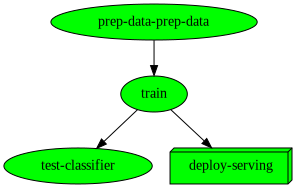

uid,start,state,name,parameters,results
...b2f210b9,Mar 08 08:35:52,completed,test-classifier,label_column=label,accuracy=1.0test-error=0.0auc-micro=1.0auc-weighted=1.0f1-score=1.0precision_score=1.0recall_score=1.0
...8a8938fe,Mar 08 08:35:40,completed,train,label_column=label,accuracy=1.0f1_score=1.0precision_score=1.0recall_score=1.0auc-micro=1.0auc-macro=1.0auc-weighted=1.0
...eb205f18,Mar 08 08:35:28,completed,prep-data-prep_data,label_column=label,num_rows=150


In [29]:
model_name="iris"
run_id = project.run(
    'main',
    arguments={'source_url' : source_url, "model_name": model_name}, 
    #dirty=True,
    engine=engine,
    watch=True)

### Viewing the end to end workflow in the UI

On the **Projects** dashboard page, select the project and then select "jobs and workflows", then go to the workflow tab and click on the workflow link.

![workflow](../assets/images/workflow.png)

## Done!

Congratulation! You've completed the Iguazio quick start tutorials.